In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano

In [24]:
P=np.array([[0.8,0.1,0.1],[0.05,0.9,0.05],[0.15,0.15,0.7]])
P

array([[ 0.8 ,  0.1 ,  0.1 ],
       [ 0.05,  0.9 ,  0.05],
       [ 0.15,  0.15,  0.7 ]])

In [25]:
def unconditionalProbability(Ptrans):
   """Compute the unconditional probability for the states of a
   Markov chain."""

   m = Ptrans.shape[0]

   P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

   I = np.eye(m)
   U = np.ones((m, m))
   u = np.ones(m)

   return np.linalg.solve((I - P + U).T, u)


In [26]:
# equilibrium probabilities
PU = unconditionalProbability(P[:,:-1])
print(PU)

[ 0.27272727  0.54545455  0.18181818]


In [27]:
Pt=P[:,:-1]
print(1. - Pt.sum(axis=1))
print(np.concatenate((Pt.T,[1. - Pt.sum(axis=1)])).T)

[ 0.1   0.05  0.7 ]
[[ 0.8   0.1   0.1 ]
 [ 0.05  0.9   0.05]
 [ 0.15  0.15  0.7 ]]


In [28]:
# create a sample
firstpoint = np.random.choice(3, 1, p=PU)
print(firstpoint)
sample = [firstpoint[0]]
for i in range(1,1000):
    sample = np.concatenate((sample,np.random.choice(3,1,p=P[sample[-1]])))

[1]


(array([ 1.51,  0.  ,  0.  ,  0.  ,  0.  ,  2.79,  0.  ,  0.  ,  0.  ,  0.7 ]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

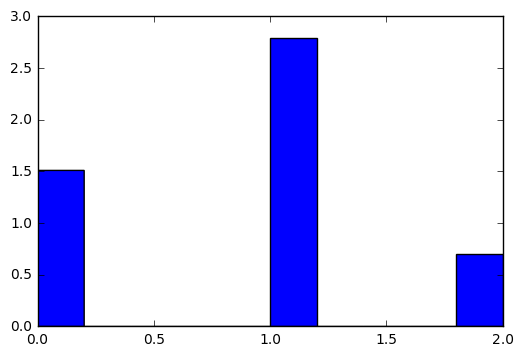

In [29]:
plt.hist(sample, normed=True)

(-0.2, 2.2)

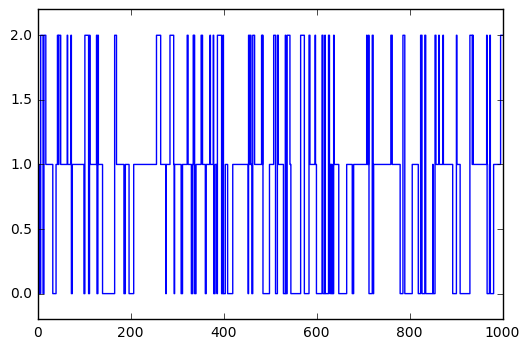

In [30]:
plt.plot(sample[:1000], drawstyle='steps-mid')
plt.ylim((-0.2,2.2))

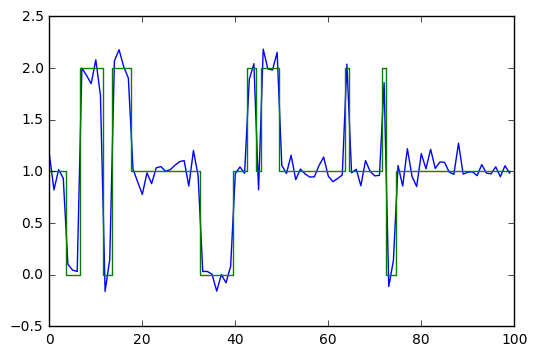

In [31]:
measurement = sample + 0.1*np.random.randn(1000)
plt.plot(measurement[:100])
plt.plot(sample[:100], drawstyle='steps-mid')

In [32]:
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla
# Two state model for simplicity.
N_states = 3
N_chain = len(sample)

# Transition probability stochastic
theta = np.ones((N_states,N_states)) + 1.
alphaA = np.ones(N_states)*2.1
betaA = np.ones(N_states)*1.1
alphaS = np.ones(N_states)*2.1
betaS = np.ones(N_states)*1.1

In [33]:
class HMMStatesN(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, PA=None, P=None, N_states=2,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.k = N_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        P = self.P
        PA = self.PA
        
        # calculate equilibrium
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        #P = tt.switch(x[:-1],P1,P2)
        
        PS = P[x[:-1]]
                
        x_i = x[1:]
        ou_like = pm.Categorical.dist(PS).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)


In [34]:
class HMMGaussianEmissionsN(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A=None, S=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissionsN, self).__init__(*args, **kwargs)
        self.A = A
        self.S = S
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A = self.A
        S = self.S
        states = self.states
        
        AS = A[states]        
        SS = S[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)


In [35]:
from scipy import optimize
with pm.Model() as model:
    # N_states state model
    #P = tt.stack( [pm.Dirichlet('P_'+str(i), a=np.ones(N_states)) for i in range(N_states)] )
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    A = pm.InverseGamma('A',alpha=alphaA, beta=betaA, shape=(N_states))
    S = pm.InverseGamma('S', alpha=alphaS, beta=betaS, shape=(N_states))
    
#    Pfull = tt.dmatrix('Pfull')
#    PA = tt.dmatrix('PA')
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',PA=PA, P=P, N_states=N_states, shape=(len(measurement)))
    
    emission = HMMGaussianEmissionsN('emmision', A=A, S=S, states=states, observed=measurement)
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P,A,S,PA,emission])
    step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    trace = pm.sample(10000, start=start, step=[step1,step2])


Optimization terminated successfully.
         Current function value: 1019.867668
         Iterations: 3
         Function evaluations: 453


100%|██████████| 10000/10000 [17:00:18<00:00,  2.32it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145745d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x145ce5198>]], dtype=object)

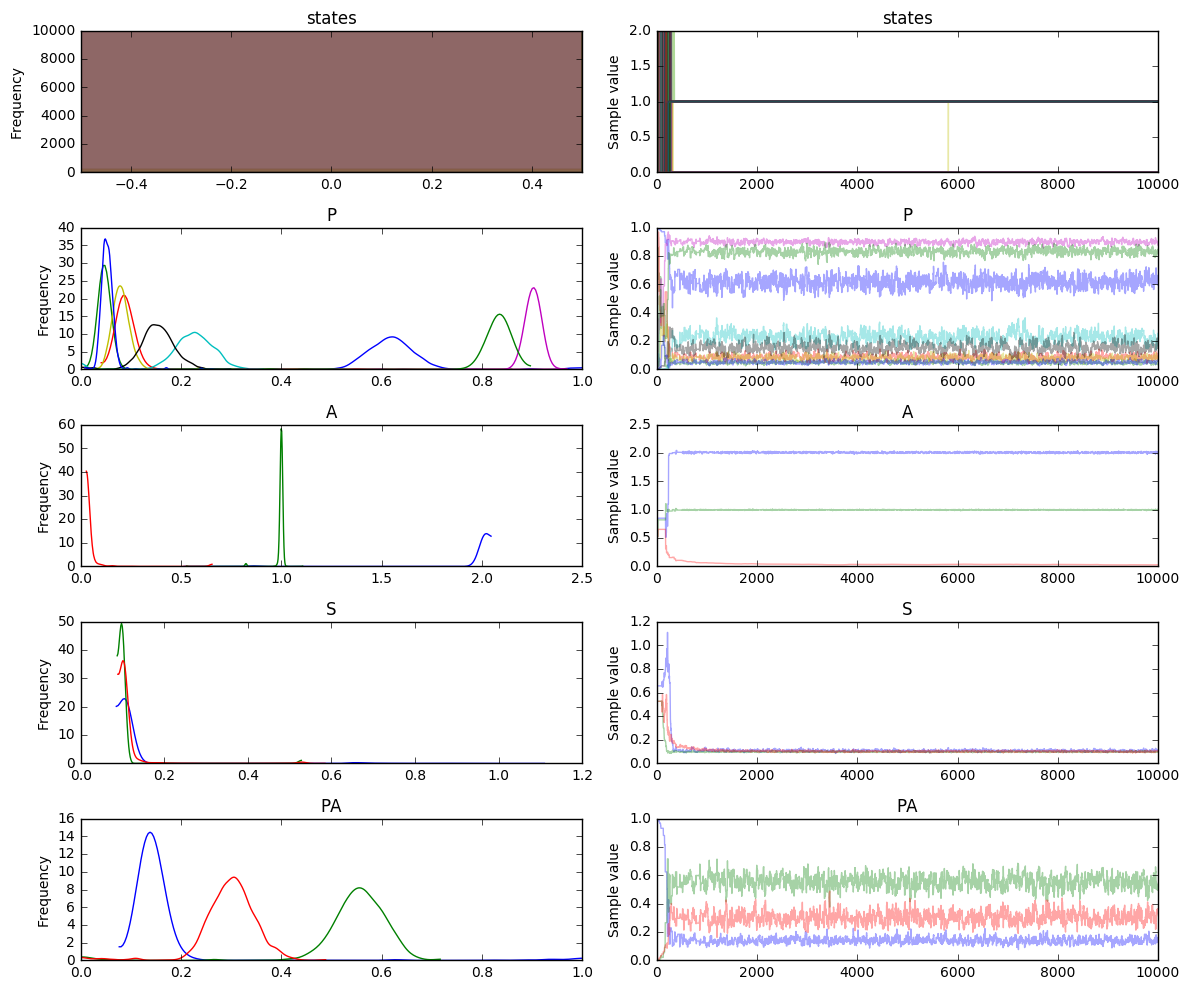

In [36]:
%matplotlib inline
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145cfc128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x154579048>]], dtype=object)

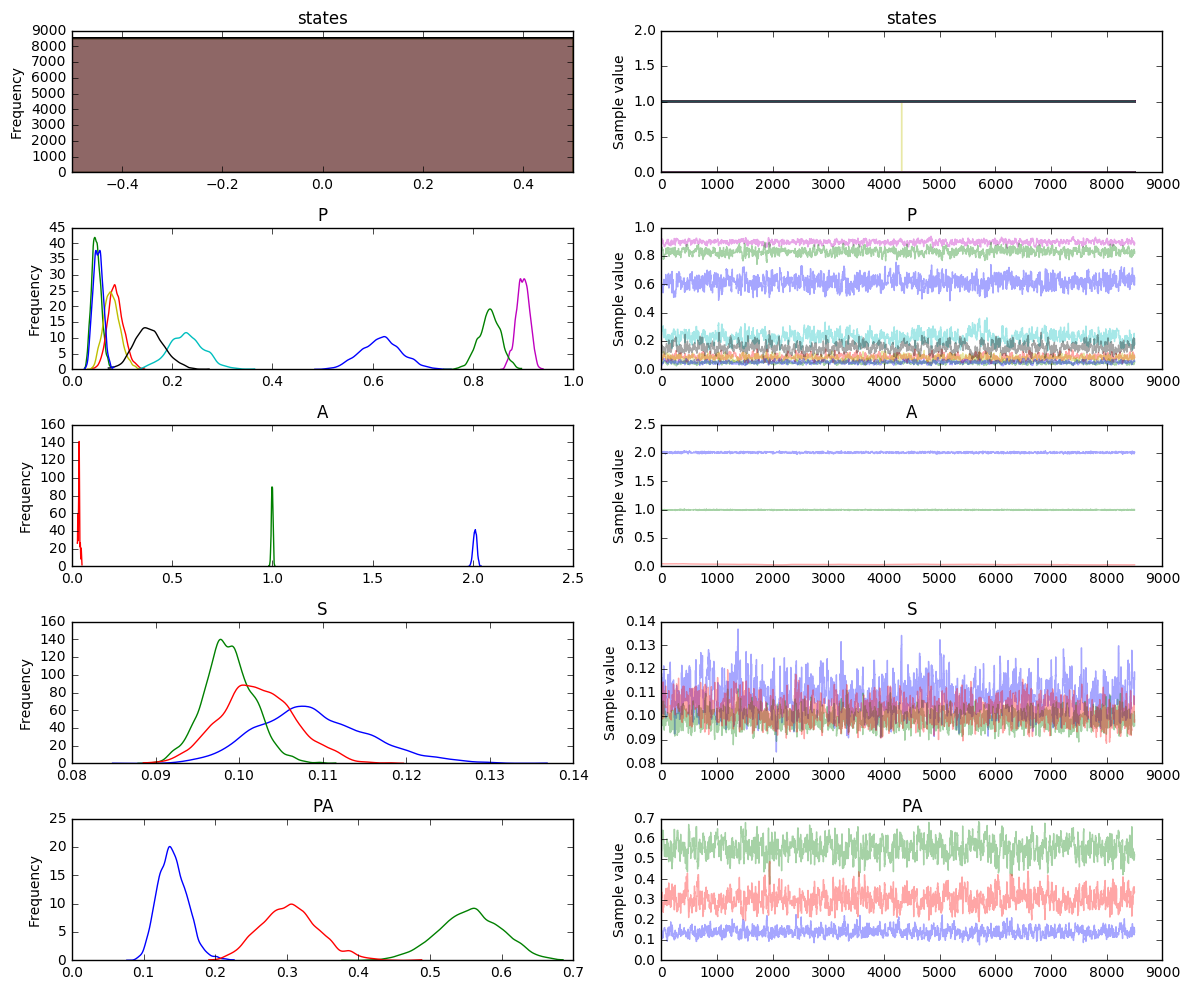

In [37]:
pm.traceplot(trace[1500:])

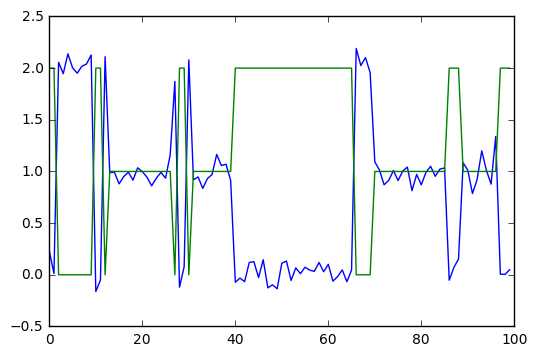

In [38]:
sample_avg=np.average(trace['states'][1000:],axis=0)
plt.plot(measurement[100:200])
plt.plot(sample_avg[100:200])